#### Part I: Data Augmentation Task from 2 combined Roboflow datasets
- These two out of 5 other datasets were not yet augmented and the best labeled in bounding box format:
  - https://universe.roboflow.com/eyhackathon2024/master-apaav/dataset/2
  - https://universe.roboflow.com/sampaiathenstak/buildings-ditz1/dataset/14

In [2]:
from google.colab import drive
import os
from pathlib import Path

# For Google Colab:
def mount_google_drive():
    drive_mount_path = '/content/drive'
    try:
        if not os.path.ismount(drive_mount_path):
            drive.mount(drive_mount_path)
            print("Google Drive mounted successfully.")
        else:
            print("Google Drive is already mounted.")
    except Exception as e:
        print(f"Failed to mount Google Drive: {e}")


def find_and_change_dir(target_dir, start_path='/'):
    # Try to find the target directory
    for root, dirs, files in os.walk(start_path):
        if target_dir in dirs:
            full_path = os.path.join(root, target_dir)
            print(f"Success: Found the directory at {full_path}")
            os.chdir(full_path)
            print(f"Success: Changed directory to {full_path}")
            return True
    print("Failure: Could not find the target directory.")
    return False

def create_path_to_folder(sub_folder):
    # Check if the sub-folder exists and create a path
    if os.path.exists(sub_folder):
        full_path = os.path.abspath(sub_folder)
        print(f"Success: Found the folder {sub_folder}. Full path is {full_path}")
        return full_path
    else:
        print(f"Failure: The folder {sub_folder} does not exist.")
        return None


# Mount the Drive
mount_google_drive()

# Start by finding and changing directory to CIS4496_EY
if find_and_change_dir('CIS4496_EY'):
    # If successful, create path to given/OtherTeamsData folder
    other_teams_data_path = create_path_to_folder('given/OtherTeamData')
    if other_teams_data_path:
        print(f"Ready for further actions in {other_teams_data_path}")
    else:
        print("Could not proceed to the next step.")
else:
    print("Please ensure the CIS4496_EY directory exists and is accessible from the mounted drive.")


Mounted at /content/drive
Google Drive mounted successfully.
Success: Found the directory at /content/drive/MyDrive/EYProject/CIS4496_EY
Success: Changed directory to /content/drive/MyDrive/EYProject/CIS4496_EY
Success: Found the folder given/OtherTeamData. Full path is /content/drive/MyDrive/EYProject/CIS4496_EY/given/OtherTeamData
Ready for further actions in /content/drive/MyDrive/EYProject/CIS4496_EY/given/OtherTeamData


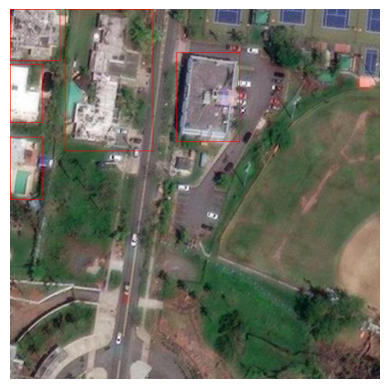

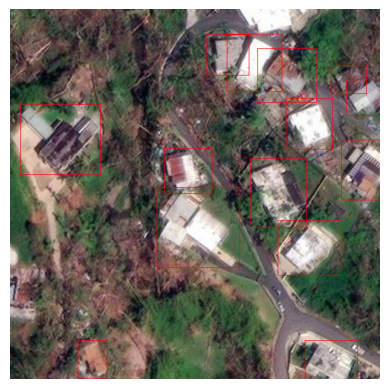

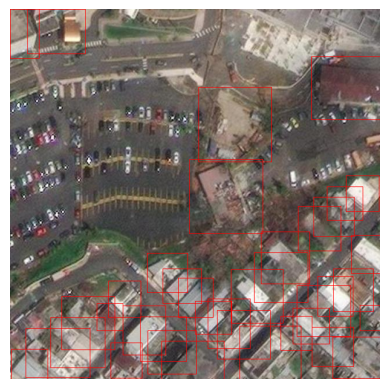

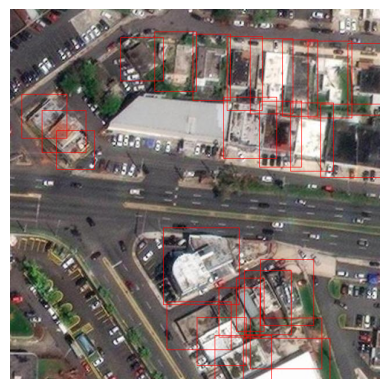

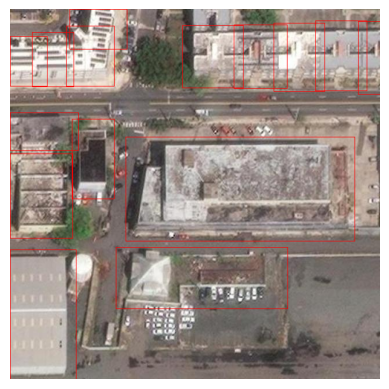

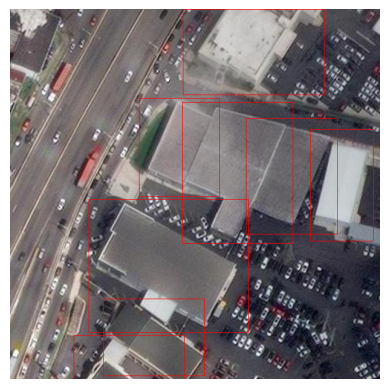

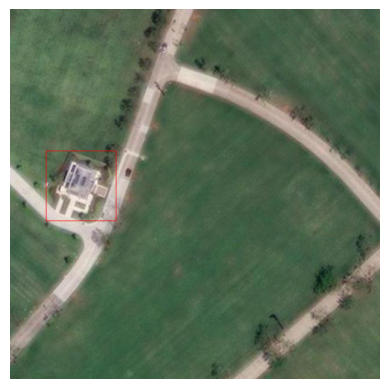

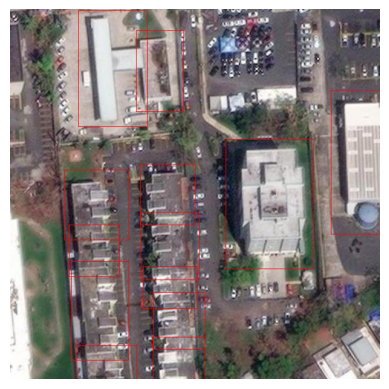

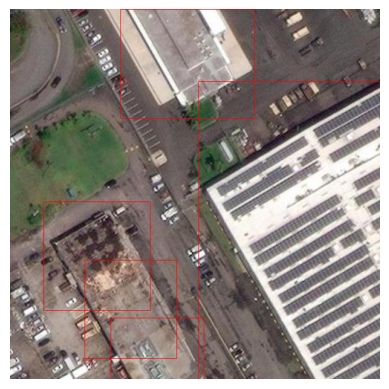

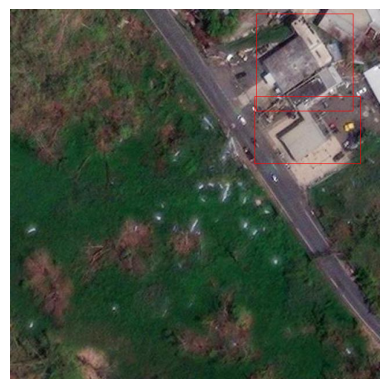

In [3]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import os

def visualize_annotation(image_path, annotation_path):
    """Visualizes YOLO format annotations on a given image by drawing rectangles."""
    image = Image.open(image_path)
    img_width, img_height = image.size
    draw = ImageDraw.Draw(image)
    with open(annotation_path, 'r') as file:
        for line in file:
            _, x_center, y_center, width, height = line.strip().split()
            # Convert normalized coordinates back to pixel coordinates
            x_center, y_center, width, height = float(x_center), float(y_center), float(width), float(height)
            x_center, y_center, width, height = (x_center * img_width, y_center * img_height, width * img_width, height * img_height)

            # Calculate top-left and bottom-right corners of the bounding box
            top_left = (x_center - width / 2, y_center - height / 2)
            bottom_right = (x_center + width / 2, y_center + height / 2)

            draw.rectangle([top_left, bottom_right], outline='red')
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Paths to the images and annotations directories dynamically built
current_dir = os.getcwd()
images_dir = os.path.join(current_dir, "given/OtherTeamData")  # Corrected path join
annotations_dir = images_dir  # Assuming annotations are in the same directory

try:
    # Select the first 10 image files for demonstration
    image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')][:10]

    for image_file in image_files:
        annotation_file = image_file.replace('.jpg', '.txt')
        if os.path.exists(os.path.join(annotations_dir, annotation_file)):
            visualize_annotation(os.path.join(images_dir, image_file), os.path.join(annotations_dir, annotation_file))
        else:
            print(f"Annotation file does not exist for {image_file}")
except FileNotFoundError as e:
    print(f"Error: {e}")



#### Also, the image size changes halfway through the list, so be prepared to handle this

The work below applies various augmentation techniques like horizontal and vertical flipping, rotation, brightness and contrast adjustments, grayscale conversion, blurring, and Gaussian noise using Albumentations library.

In [15]:
# Step 1: Install libraries for Data Augmentation
# Use Albumentations and its dependencies
# Documentation: https://github.com/albumentations-team/albumentations

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import numpy as np
import os, shutil

# Create directory for augmented data if it doesn't exist
augmented_data_dir = 'augmented_data'
if not os.path.exists(augmented_data_dir):
    os.makedirs(augmented_data_dir)

In [8]:
# Step 2: Define augmentation transforms and initialize paths to images

# Use the RandomBrightnessContrast transform instead of the deprecated RandomBrightness and RandomContrast version
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.ToGray(p=0.5),
    A.Blur(p=0.5),
    A.GaussNoise(p=0.5),
    ToTensorV2()
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

# Paths to the images and annotations directories dynamically built
current_dir = os.getcwd()
images_dir = os.path.join(current_dir, "given/OtherTeamData")
annotations_dir = images_dir

In [16]:
# Step 3: Loop through images and annotations

for image_file in os.listdir(images_dir):
    if image_file.endswith('.jpg'):
        # Load image and annotations
        image_path = os.path.join(images_dir, image_file)
        annotation_path = os.path.join(annotations_dir, image_file.replace('.jpg', '.txt'))

        if os.path.exists(annotation_path):
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            with open(annotation_path, 'r') as file:
                bboxes = []
                class_labels = []
                for line in file:
                    class_id, x, y, w, h = map(float, line.strip().split())
                    bboxes.append([x, y, w, h])
                    class_labels.append(int(class_id))

            # Apply augmentations
            augmented = transform(image=image, bboxes=bboxes, class_labels=class_labels)
            augmented_image = augmented['image']
            augmented_bboxes = augmented['bboxes']
            augmented_class_labels = augmented['class_labels']

            # Convert augmented image to NumPy array
            augmented_image = augmented_image.permute(1, 2, 0).numpy()

            # Save augmented images and annotations
            augmented_data_path = os.path.join(augmented_data_dir, image_file)
            augmented_annotation_path = os.path.join(augmented_data_dir, image_file.replace('.jpg', '.txt'))

            cv2.imwrite(augmented_data_path, cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR))

            with open(augmented_annotation_path, 'w') as file:
                for bbox, class_label in zip(augmented_bboxes, augmented_class_labels):
                    file.write(f"{int(class_label)} {bbox[0]} {bbox[1]} {bbox[2]} {bbox[3]}\n")

        else:
            print(f"Annotation file does not exist for {image_file}")

In [17]:
# Step 4: Verify how many augmentations were created

def count_jpg_files(folder):
    jpg_count = 0
    for file in os.listdir(folder):
        if file.endswith(".jpg"):
            jpg_count += 1
    return jpg_count

augmented = "/content/drive/MyDrive/EYProject/CIS4496_EY/augmented_data"
original = "/content/drive/MyDrive/EYProject/CIS4496_EY/given/OtherTeamData"

jpg_count_folder1 = count_jpg_files(augmented)
jpg_count_folder2 = count_jpg_files(original)

if jpg_count_folder1 == jpg_count_folder2:
    print("The number of .jpg files in both folders is the same:", jpg_count_folder1)
else:
    print("The number of .jpg files in the folders is different.")

The number of .jpg files in both folders is the same: 356


Conclusion: Albumentations only generated 1 augmented file to each original image while maintaining the bounding boxes annotations and modifying the corresponding coordinates. Each augmentation is completely random and might consist several methods at once, but I think it's necessary to increase the number of augmented images.

### Part II: Semantic Segmentation for Rio